In [1]:
import os
import sys
# On ajoute le dossier modeling au PYTHONPATH
sys.path.append(os.path.abspath("modeling"))

# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [2]:
import os

# import numpy as np
import pandas as pd
import cudf
import cuml

# import gc
# import cupy as cp
# from cuml.pipeline import Pipeline

import matplotlib.pyplot as plt

# import seaborn as sns
import joblib
import lightgbm as lgb

# from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import warnings
from mlflow import MlflowClient

warnings.simplefilter(action="ignore", category=FutureWarning)
## np.warnings.filterwarnings("ignore", r"All-NaN (slice|axis) encountered")
# np.seterr(all="ignore", invalid="ignore")

In [3]:


from src.constantes import (
    DATA_INTERIM,
    VAL_SEED,
)
from src.p7_missing_values import missing_values_barh
from src.p7_util import reduce_memory_cudf

%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

In [4]:
print("cuDF version:", cudf.__version__)
print("cuML version:", cuml.__version__)

cuDF version: 24.04.01
cuML version: 24.04.00


# Lecture des données de Train

In [5]:
train = cudf.read_csv(os.path.join(DATA_INTERIM, "01_v0_built_train.csv"))
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 747 entries, SK_ID_CURR to CC_COUNT
dtypes: bool(160), float64(517), int64(70)
memory usage: 1.1 GB


In [6]:
train = reduce_memory_cudf(train)

Memory usage of dataframe is 1086.93 MB
Memory usage after optimization is: 600.40 MB
Decreased by 44.8%


# 1er aperçu

## Colonnes comportant le plus de valeurs manquantes

Taille estimée de figure pour 80 variables : (8, 17.0)


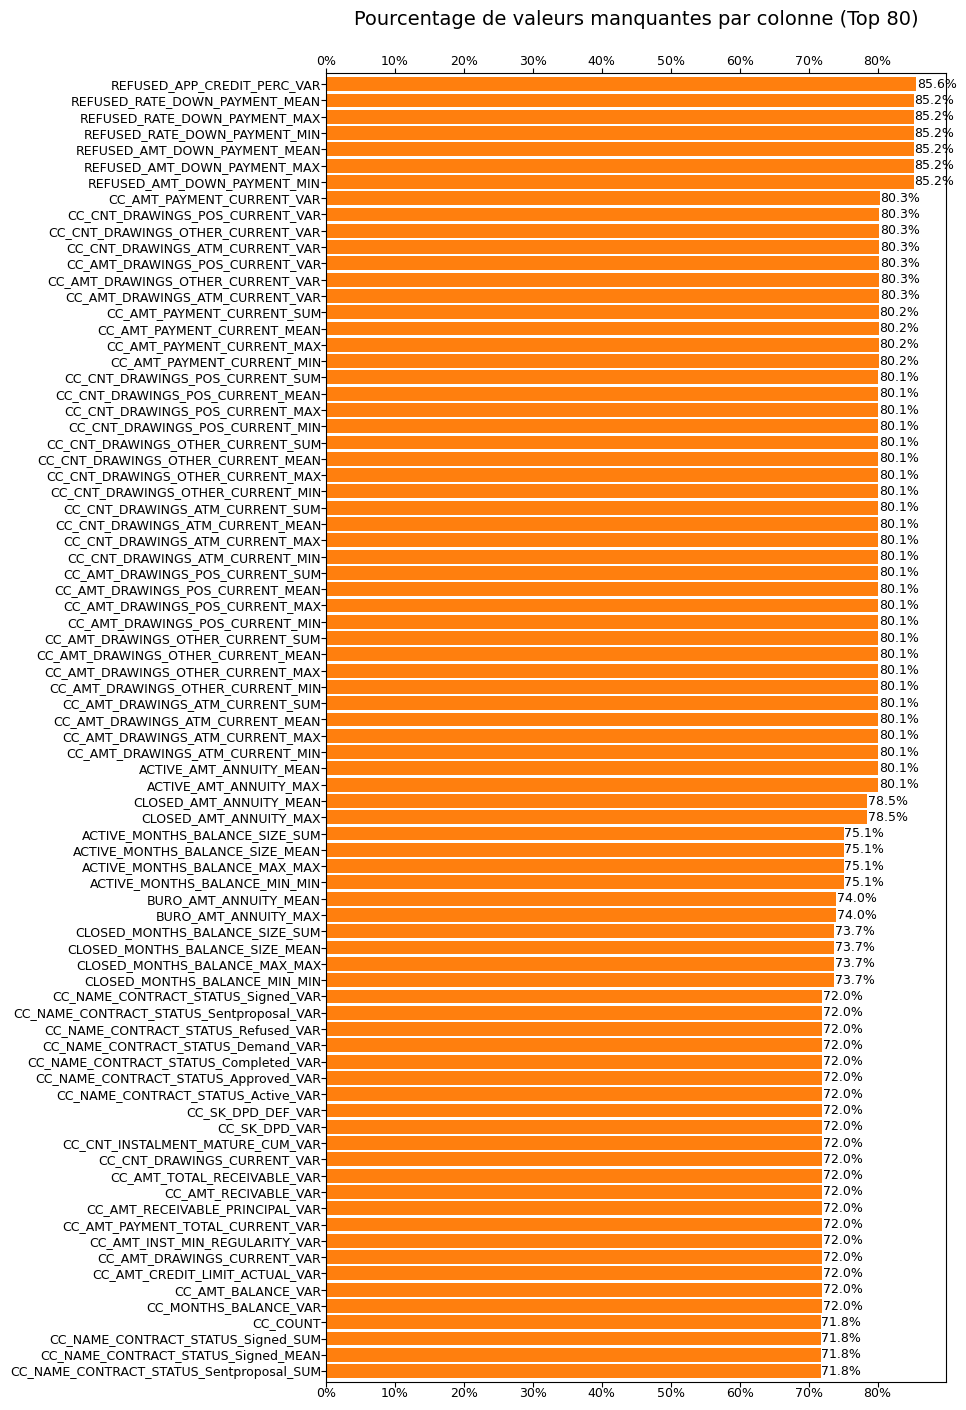

In [8]:
_ = missing_values_barh(train, sort="value", n_max=80, verbose=True)

In [ ]:
"""
Ce bref aperçu nous indique qu'il va falloir supprimer des colonnes qui ont trop de valeurs manquantes,
En effet nous n'allons pas imputer sur des colonnes comportant plus de 30% de valeurs manquantes.
Pour éviter de supprimer des features trop importantes,nous allons utiliser un premier modèle d'arbres de décision
pour estimer les features les plus importantes.
"""

"\nCe bref aperçu nous indique qu'il va falloir supprimer des colonnes qui ont trop de valeurs manquantes,\nEn effet nous n'allons pas imputer sur des colonnes comportant plus de 30% de valeurs manquantes.\nPour éviter de supprimer des features trop importantes, nous allons explorer les features les plus corrélées avec la Target,\net utiliser un premier modèle d'arbres de décision pour estimer les features les plus importantes.\n"

## Proportion de défaut

In [ ]:
def plot_default_ratio(series):
    labels = ["Remb. Ok", "Défaut"]
    # Plot en camembert
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.suptitle(
        f"Pourcentage de prêts avec et sans défaut de remboursement\nNombre d'observations : {len(series):_}",
        ha="left",  # Aligne les deux ligne du titre sur leur gauche
        x=0.0,  # Positionne les lignes du titres complètement à gauche
    )
    ratio = series.value_counts(normalize=True)
    # Si on a un cudf la conversion en numpy est nécessaire. Si on a un pd.df, la conversion ne nuit pas.
    ax.pie(
        series.value_counts(normalize=True).to_numpy(),
        labels=labels,
        autopct="%.1f%%",
    )

    fig.legend(loc="lower right")
    fig.tight_layout()
    return fig

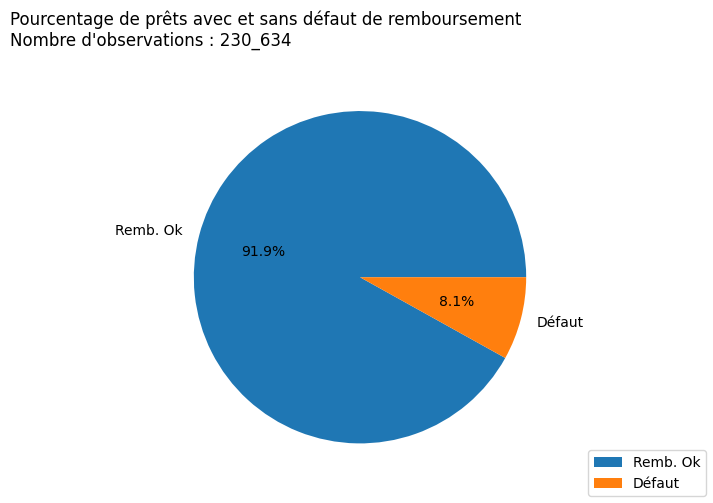

In [9]:
_ = plot_default_ratio(train["TARGET"])

# Valeurs manquantes et importances

## Calcul des importances avec LightGBM API sklearn

In [11]:
"""
Le modèle lightGBM a l'avantage d'accepter les valeurs manquante et d'être relativement rapide.
Nous allons l'utiliser avec des hyperparamètres par défaut (excepté le rééquilibrage), en validation croisée.
"""

"\nLe modèle lightGBM a l'avantage d'accepter les valeurs manquante et d'être relativement rapide.\nNous allons l'utiliser avec des hyperparamètres par défaut (excepté le rééquilibrage), en validation croisée.\n"

### Paramètres par défaut

In [12]:
clf = lgb.LGBMClassifier()
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Predictors, X, y

In [13]:
predictors = [f for f in train.columns if f not in ["SK_ID_CURR", "TARGET"]]
X = train[predictors].to_pandas()
y = train["TARGET"].to_pandas()
print("Info X :")
print(X.info())
print("\nInfo y :")
print(y.info())

Info X :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 745 entries, CODE_GENDER to CC_COUNT
dtypes: bool(158), float32(497), float64(82), int32(6), int64(2)
memory usage: 625.1 MB
None

Info y :
<class 'pandas.core.series.Series'>
RangeIndex: 230634 entries, 0 to 230633
Series name: TARGET
Non-Null Count   Dtype
--------------   -----
230634 non-null  int32
dtypes: int32(1)
memory usage: 901.0 KB
None


### Importances moyennes en validation croisées (dataset rééquilibré par class_weight)

In [ ]:
clf = lgb.LGBMClassifier(
    nthread=14,
    class_weight="balanced",
    objective="binary",
    random_state=VAL_SEED,
    verbosity=-1,  # Pour ne pas voir les logs
)
params_lgbm_clf = clf.get_params()
print("Pramètres du cmassifieur LightGBM :")
print(params_lgbm_clf)

folds = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=VAL_SEED,
)
all_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y), start=1):
    X_train, y_train = (
        X.iloc[train_idx],
        y.iloc[train_idx],
    )
    X_val, y_val = (
        X.iloc[valid_idx],
        y.iloc[valid_idx],
    )
    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        # eval_metric="auc",
    )
    # y_score_val = clf.predict(X_val)
    # A chaque fold, on crée un df contenant les importances du fold avec 3 colonnes :
    # 1: nom de la feature, 2 : son importance sur le fold, 3 : le n° du fold
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    # On concatène les df de fold les uns en dessous des autres dans un df qui contient toutes les importances
    all_importance_df = pd.concat([all_importance_df, fold_importance_df], axis=0)

Pramètres du cmassifieur LightGBM :
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': 14, 'verbosity': -1}


## Aggrégations des importances au travers des folds

In [15]:
def mean_importance_from_all_folds(importance_folds, X=None):
    # On calcule la moyenne et l'écart type des importances obtenus sur les folds
    # en les triant de la plus haute importance à la plus basse
    mean_importance = (
        importance_folds.drop("fold", axis=1)
        .groupby("feature")
        .agg(
            importance_mean=("importance", "mean"),
            importance_std=("importance", "std"),
        )
        .sort_values(by="importance_mean", ascending=False)
    )

    # On ajoute une colonne Rank (pour pouvoir trier / détrier dans n'importe quel sens par la suite)
    ranks = range(1, len(mean_importance) + 1)
    mean_importance["rank_importance"] = ranks
    df_res = mean_importance

    # Si X est fourni on ajoute le pourcentage de valeurs manquantes pour chaque feature
    if X is not None:
        missing_df = pd.DataFrame(X.isna().mean() * 100, columns=["missing_pct"])
        df_res = mean_importance.join(missing_df)

    return df_res

In [16]:
mean_importances = mean_importance_from_all_folds(
    importance_folds=all_importance_df, X=X
)
mean_importances.head()

,importance_mean,importance_std,rank_importance,missing_pct
feature,,,,
EXT_SOURCE_1,120.4,5.029911,1,56.289185
EXT_SOURCE_2,112.0,3.807887,2,0.208556
CREDIT_TO_ANNUITY_RATIO,99.8,9.257429,3,0.003469
EXT_SOURCE_3,95.4,4.827007,4,19.816679
DAYS_EMPLOYED,63.8,5.805170,5,18.019459


In [17]:
mean_importances.tail()

,importance_mean,importance_std,rank_importance,missing_pct
feature,,,,
ORGANIZATION_TYPE_NA,0.0,0.0,741,0.000000
ORGANIZATION_TYPE_Mobile,0.0,0.0,742,0.000000
ORGANIZATION_TYPE_Medicine,0.0,0.0,743,0.000000
ORGANIZATION_TYPE_LegalServices,0.0,0.0,744,0.000000
POS_NAME_CONTRACT_STATUS_Demand_MEAN,0.0,0.0,745,5.825247


## Sauvegarde des importances 01_v0_importances.csv

In [19]:
filepath_importance = os.path.join(DATA_INTERIM, "01_v0_importances.csv")
mean_importances.to_csv(filepath_importance, index=True)
print(f"Importances moyennes enregistrés dans {filepath_importance}")
mean_importances.info()

Importances moyennes enregistrés dans data/interim/01_v0_importances.csv
<class 'pandas.core.frame.DataFrame'>
Index: 745 entries, EXT_SOURCE_1 to POS_NAME_CONTRACT_STATUS_Demand_MEAN
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   importance_mean  745 non-null    float64
 1   importance_std   745 non-null    float64
 2   rank_importance  745 non-null    int64  
 3   missing_pct      745 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 45.3+ KB


## Graphiques

### Graphique global missing et importance 

Avec différence de couleur entre les missign > 30% et les autres

In [215]:
def plot_line_importance_with_missing(
    mean_importances,
    col_importance="importance_mean",
    col_rank="rank_importance",
    col_missing="missing_pct",
):
    threshold_missing = 30
    color_missing_inf30 = "green"
    color_missing_sup30 = "orange"
    color_importance = "blue"

    fig, ax_importance = plt.subplots(figsize=(10, 6))

    # Séparer les points selon le seuil 30% de valeurs manquantes
    below_thresh = mean_importances[mean_importances[col_missing] <= threshold_missing]
    above_thresh = mean_importances[mean_importances[col_missing] > threshold_missing]

    # Axe de gauche : importance
    min_rank_importance = mean_importances[col_rank].min()
    max_rank_importance = mean_importances[col_rank].max()

    ax_importance.set_xlabel(
        f"Rang d'Importance de la Feature ({min_rank_importance} = la + plus importante, {max_rank_importance} = la - importante)"
    )

    ax_importance.set_ylabel("Importance", color=color_importance)
    ax_importance.tick_params(axis="y", labelcolor=color_importance)
    ax_importance.set_ylabel("Importance moyenne (nb splits)")

    # Axe de droite : pourcentage de valeurs manquantes
    ax_missing = ax_importance.twinx()

    ax_missing.set_ylabel("Pourcentage de valeurs manquantes")
    # Définir les ticks personnalisés pour l'axe des % de missing (pour que la grille tombe à des endroits "souhaités")
    missing_custom_ticks = [30, 40, 50, 60, 70, 80, 90]
    ax_missing.set_yticks(missing_custom_ticks)

    # Activer la grille uniquement pour l'axe de droite, avec ces ticks
    ax_missing.yaxis.grid(
        True, which="major", color="lightgrey", linestyle="--", linewidth=0.7
    )

    # On trace la ligne qui représente l'importance
    line_importance = ax_importance.plot(
        mean_importances[col_rank],
        mean_importances[col_importance],
        color=color_importance,
        marker="o",
        markersize=3,
        linewidth=0.7,
        label="Importance",
    )

    # On trace les points < 30% de missing en orange
    line_missing_inf30 = ax_missing.plot(
        below_thresh[col_rank],
        below_thresh[col_missing],
        color=color_missing_inf30,
        marker="o",
        linestyle="None",
        markersize=2,
        label=f"% manquantes ≤ {threshold_missing}%",
    )

    # On trace les points au pourcentage de valeurs manquantes >= 30% en orange
    line_missing_sup30 = ax_missing.plot(
        above_thresh[col_rank],
        above_thresh[col_missing],
        color=color_missing_sup30,
        marker="v",
        linestyle="None",
        markersize=5,
        label=f"% manquantes > {threshold_missing}%",
    )

    # Titre et mise en page
    plt.title("Etude des features : Importance & Valeurs manquantes\n\n\n")

    # Combine les légendes
    lines = line_importance + line_missing_inf30 + line_missing_sup30
    labels = [l.get_label() for l in lines]

    # Légende en dehors du graphique (sinon illisible)
    ax_importance.legend(
        lines,
        labels,
        loc="lower left",  # Position dans la boîte définie par bbox
        bbox_to_anchor=(0.0, 1.02),  # Juste au-dessus du graphique, aligné à gauche
        ncol=3,  # Légende sur une seule ligne
        # frameon=True,
        # framealpha=1.0,
        # facecolor="lightgrey",
        edgecolor="black",
        fontsize=9,
        borderpad=0.8,
    )

    fig.tight_layout()
    plt.grid(True)
    return fig

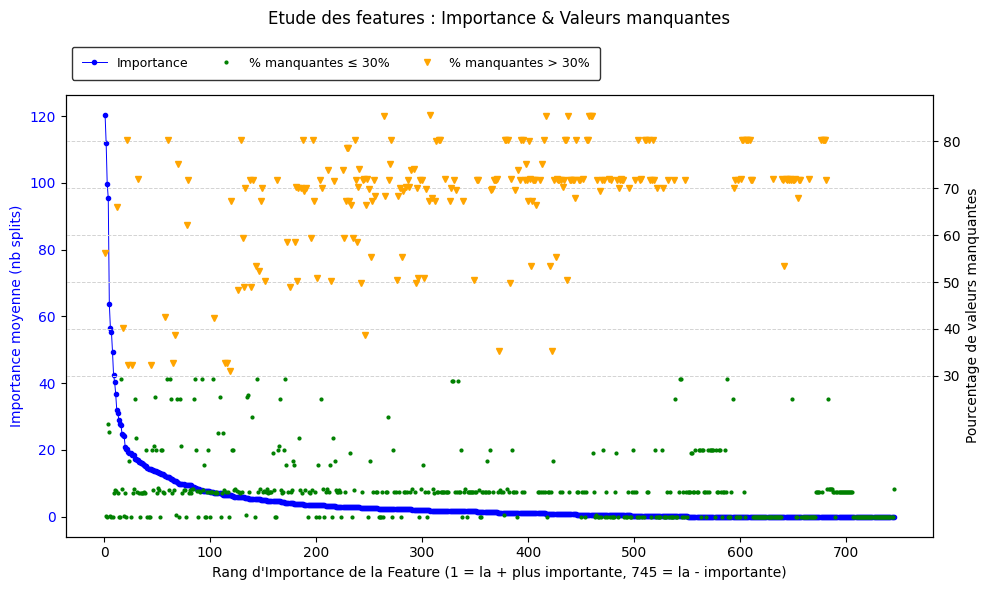

In [216]:
fig_line_importance_with_missing = plot_line_importance_with_missing(mean_importances)

### Graphiques en barres

In [217]:
# Display/plot feature importance
def plot_bar_importances(
    mean_importance,
    col_mean="importance_mean",
    col_std="importance_std",
    top=40,
    sort_by_name=False,
    save_img=False,
):
    best_importance = mean_importance.head(top)
    # Barh inverse l'ordre donc on trie en sens inverse
    if sort_by_name:
        best_importance = best_importance.sort_values(by="feature", ascending=False)
    else:
        best_importance = best_importance.sort_values(by=col_mean, ascending=True)

    # Taille de la figure
    width = 8
    margin = 1
    bar_height = 0.25
    height = margin + bar_height * top

    # print(best_importance)
    fig = plt.figure(figsize=(width, height))
    # Récupère l'axe en cours
    ax = plt.gca()

    barplot = best_importance[col_mean].plot(kind="barh", width=0.85)

    # Récupérer les coordonnées des barres du barplot
    x_positions = [bar.get_width() for bar in barplot.patches]
    y_positions = [bar.get_y() + bar.get_height() / 2 for bar in barplot.patches]

    # Ajouter les barres d'erreur
    plt.errorbar(
        x=x_positions,
        y=y_positions,
        # data=best_importance,
        xerr=[best_importance[col_std], best_importance[col_std]],
        fmt="none",  # Aucun marqueur pour les points de données
        # capsize=5,  # Taille des barres à l'extrémité des lignes d'erreur
        color="black",  # Couleur des barres d'erreur
    )

    fig.suptitle(f"Top {top} des Features les plus importantes par LightGBM\n")
    ax.set(
        ylabel=f"Feature",
        title=f"Titre du graphique",
        xlabel=f"Importance moyenne en nombre de splits",
    )
    # ax.set_title("Titre du graphique", fontsize=10)
    plt.tight_layout()

    return fig

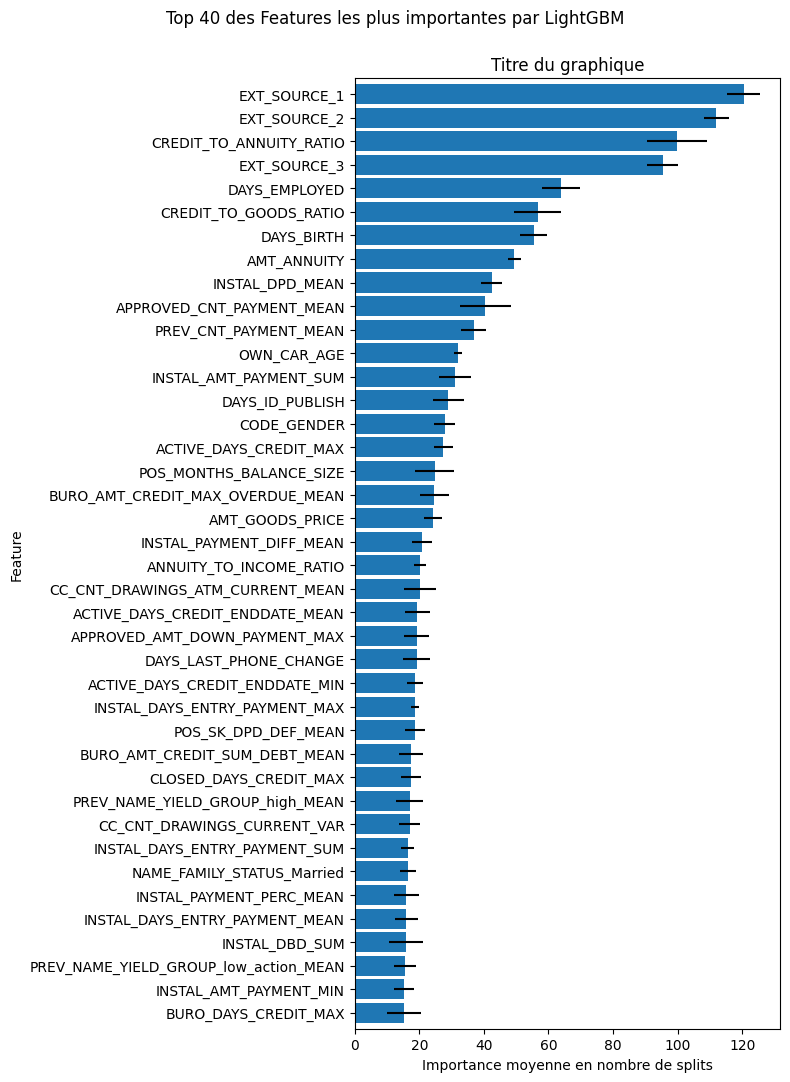

In [218]:
_ = plot_bar_importances(mean_importances)

In [219]:
mean_importances.head()

,importance_mean,importance_std,rank_importance,missing_pct
feature,,,,
EXT_SOURCE_1,120.4,5.029911,1,56.289185
EXT_SOURCE_2,112.0,3.807887,2,0.208556
CREDIT_TO_ANNUITY_RATIO,99.8,9.257429,3,0.003469
EXT_SOURCE_3,95.4,4.827007,4,19.816679
DAYS_EMPLOYED,63.8,5.805170,5,18.019459


In [220]:
def plot_bar_importances_with_missing(
    mean_importances,
    col_mean="importance_mean",
    col_std="importance_std",
    col_missing="missing_pct",
    top=40,
    sort_by_name=False,
):
    threshold_missing = 30
    best_importance = mean_importances.sort_values(by=col_mean, ascending=False).head(
        top
    )

    # Trier les données
    if sort_by_name:
        best_importance = best_importance.sort_values(by="feature", ascending=False)
    else:
        best_importance = best_importance.sort_values(by=col_mean, ascending=True)

    # Taille de la figure et sous-graphiques
    width = 10
    margin = 1
    bar_height = 0.25
    height = margin + bar_height * top

    fig, (ax1, ax2) = plt.subplots(
        ncols=2,
        figsize=(width, height),
        gridspec_kw={"width_ratios": [2, 1]},
        sharey=True,  # Partage les features sur l'axe Y
    )

    # --- Graphique 1 : importance + std ---

    best_importance.plot(
        kind="barh",
        y=col_mean,
        xerr=col_std,
        ax=ax1,
        width=0.85,
        legend=False,
        # grid=True,
        # color="skyblue",
        # edgecolor="black",
    )
    ax1.set_xlabel("Nombre de splits moyen (± écart-type)")
    ax1.set_ylabel("Feature")
    ax1.set_title("Importance moyenne sur les folds en nb de splits")
    # Activer la grille uniquement pour le plot de gauche
    ax1.yaxis.grid(
        True, which="major", color="lightgrey", linestyle="--", linewidth=0.7
    )
    ax1.set_axisbelow(True)  # Force la grille à être dessous les barres

    # --- Graphique 2 : pourcentage de valeurs manquantes ---
    best_importance.plot(
        kind="barh",
        y=col_missing,
        ax=ax2,
        width=0.85,
        legend=False,
        color="grey",
        edgecolor="grey",
    )
    ax2.axvline(x=30, color="grey", linestyle="--", label=f"Seuil {threshold_missing}%")
    # ax2.text(30 + 1, 0.5, "Seuil 30%", color="gray", fontsize=8)
    ax2.set_xlabel("% de valeurs manquantes")
    ax2.set_title("% valeurs manquantes")

    # Ajustements
    fig.suptitle(f"Top {top} des features les plus importantes LightGBM", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    return fig

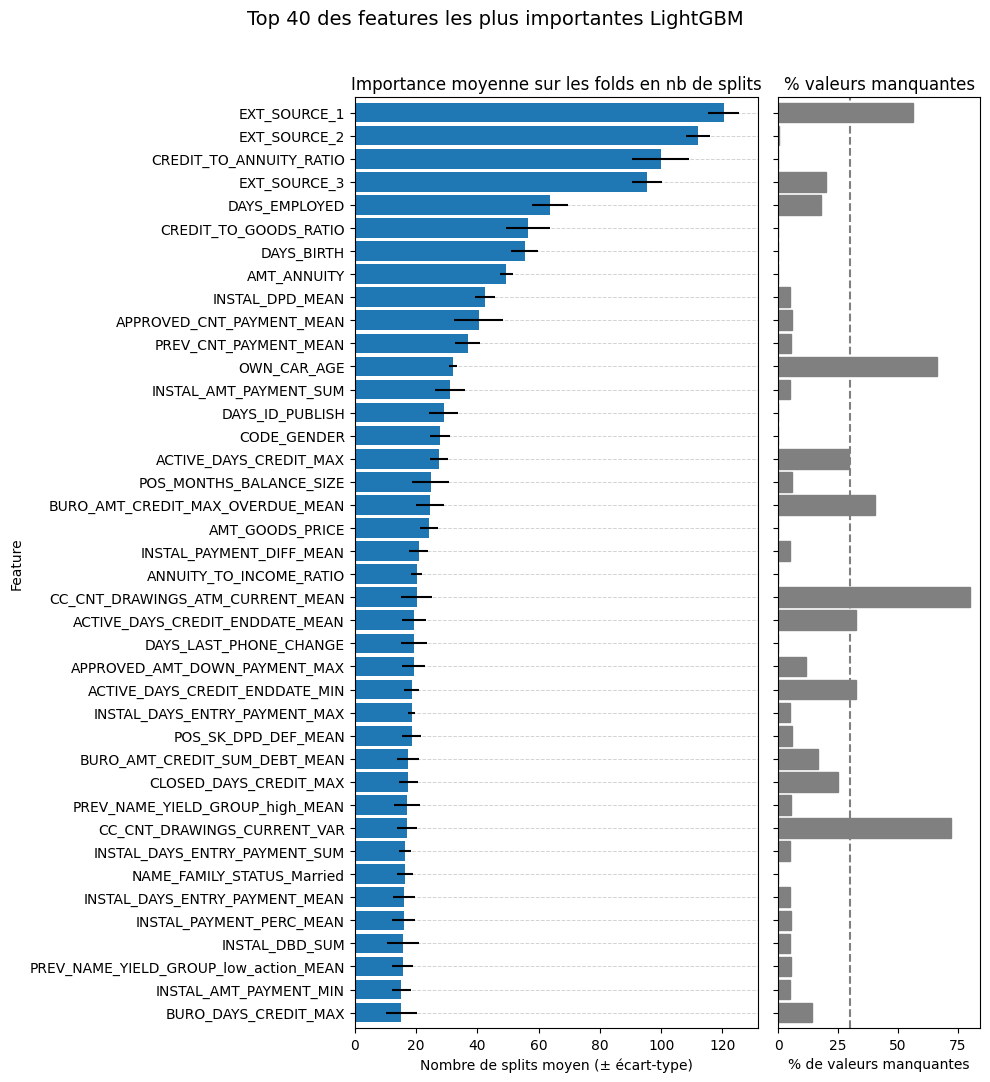

In [221]:
top40_most_important_with_missing = plot_bar_importances_with_missing(
    mean_importances, top=40
)

## Suppression des features non importantes et trop manquantes

### Sélection des features Rang >= 300 et comportant plus de 30% de valeurs manquantes

In [222]:
to_drop_rank_300 = list(
    mean_importances[
        (mean_importances["rank_importance"] >= 300)
        & (mean_importances["missing_pct"] > 30.0)
    ].index
)
print(
    f"{len(to_drop_rank_300)} features de rang d'importance >=300 et comportant plus de 30% de valeurs manquantes"
)
print(to_drop_rank_300)

143 features de rang d'importance >=300 et comportant plus de 30% de valeurs manquantes
['CC_CNT_INSTALMENT_MATURE_CUM_MEAN', 'APARTMENTS_AVG', 'COMMONAREA_MODE', 'REFUSED_AMT_CREDIT_MAX', 'REFUSED_APP_CREDIT_PERC_VAR', 'FLOORSMIN_AVG', 'REFUSED_AMT_CREDIT_MEAN', 'ACTIVE_AMT_ANNUITY_MAX', 'CC_AMT_PAYMENT_CURRENT_MEAN', 'CC_AMT_PAYMENT_CURRENT_MAX', 'CC_AMT_CREDIT_LIMIT_ACTUAL_VAR', 'REFUSED_HOUR_APPR_PROCESS_START_MEAN', 'BURO_MONTHS_BALANCE_MIN_MIN', 'CC_NAME_CONTRACT_STATUS_Sentproposal_MEAN', 'REFUSED_AMT_GOODS_PRICE_MIN', 'REFUSED_AMT_APPLICATION_MAX', 'ENTRANCES_MODE', 'CC_AMT_RECIVABLE_MEAN', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MAX', 'REFUSED_AMT_GOODS_PRICE_MAX', 'COMMONAREA_AVG', 'CC_MONTHS_BALANCE_SUM', 'CC_MONTHS_BALANCE_MEAN', 'CC_AMT_BALANCE_MIN', 'CC_CNT_INSTALMENT_MATURE_CUM_VAR', 'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN', 'CC_AMT_DRAWINGS_POS_CURRENT_SUM', 'CC_AMT_DRAWINGS_POS_CURRENT_VAR', 'CC_CNT_DRAWINGS_POS_CURRENT_VAR', 'FLOORSMAX_MODE', 'CC_AMT_RECIVABLE_VAR', 'REFUSED_AMT_GOODS_

### Sauvegarde 01_V1_miss_300_train.csv

In [223]:
filepath_train = os.path.join(DATA_INTERIM, "01_v1_miss_300_train.csv")
train.drop(columns=to_drop_rank_300).to_csv(filepath_train, index=False)
print(
    f"train après suppression des colonnes trop manquantes enregistré dans {filepath_train}"
)
train.drop(columns=to_drop_rank_300).info()

train après suppression des colonnes trop manquantes enregistré dans data/interim/01_v1_miss_300_train.csv
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 604 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(158), float32(386), float64(13), int32(33), int64(14)
memory usage: 462.7 MB


In [224]:
path_features = os.path.join(DATA_INTERIM, "01_v1_miss_300_removed_features.pkl")
joblib.dump(to_drop_rank_300, path_features)
print(f"Liste des features supprimées (trop manquantes) engistrée dans {path_features}")

Liste des features supprimées (trop manquantes) engistrée dans data/interim/01_v1_miss_300_removed_features.pkl


### Sélection des features Rang >= 200 et comportant plus de 30% de valeurs manquantes

In [225]:
to_drop_rank_200 = list(
    mean_importances[
        (mean_importances["rank_importance"] >= 200)
        & (mean_importances["missing_pct"] > 30.0)
    ].index
)
print(
    f"{len(to_drop_rank_200)} features de rang d'importance >=200 et comportant plus de 30% de valeurs manquantes"
)
print(to_drop_rank_200)

192 features de rang d'importance >=200 et comportant plus de 30% de valeurs manquantes
['APARTMENTS_MODE', 'CC_CNT_DRAWINGS_CURRENT_MAX', 'BURO_STATUS_1_MEAN_MEAN', 'CLOSED_MONTHS_BALANCE_SIZE_SUM', 'LIVINGAREA_MEDI', 'REFUSED_APP_CREDIT_PERC_MEAN', 'CLOSED_MONTHS_BALANCE_SIZE_MEAN', 'LANDAREA_MODE', 'REFUSED_DAYS_DECISION_MIN', 'CLOSED_AMT_ANNUITY_MEAN', 'CLOSED_AMT_ANNUITY_MAX', 'REFUSED_HOUR_APPR_PROCESS_START_MIN', 'YEARS_BUILD_MODE', 'LANDAREA_AVG', 'CC_AMT_PAYMENT_CURRENT_VAR', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN', 'BASEMENTAREA_MEDI', 'REFUSED_AMT_ANNUITY_MIN', 'BURO_AMT_ANNUITY_MEAN', 'FLOORSMAX_AVG', 'CC_AMT_INST_MIN_REGULARITY_SUM', 'CC_AMT_INST_MIN_REGULARITY_VAR', 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM', 'YEARS_BUILD_AVG', 'CC_AMT_DRAWINGS_CURRENT_VAR', 'COMMONAREA_MEDI', 'NONLIVINGAREA_AVG', 'REFUSED_AMT_APPLICATION_MIN', 'CC_AMT_DRAWINGS_CURRENT_MEAN', 'LIVINGAPARTMENTS_AVG', 'REFUSED_RATE_DOWN_PAYMENT_MAX', 'LIVINGAPARTMENTS_MODE', 'CC_AMT_RECEIVABLE_PRINCIPAL_MEAN', 'ACTIVE_M

### Sauvegarde 01_V1_miss_200_train.csv

In [226]:
filepath_train = os.path.join(DATA_INTERIM, "01_v1_miss_200_train.csv")
train.drop(columns=to_drop_rank_200).to_csv(filepath_train, index=False)
print(
    f"train après suppression des colonnes trop manquantes enregistré dans {filepath_train}"
)
train.drop(columns=to_drop_rank_200).info()

train après suppression des colonnes trop manquantes enregistré dans data/interim/01_v1_miss_200_train.csv
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 555 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(158), float32(345), float64(12), int32(27), int64(13)
memory usage: 416.5 MB


In [227]:
path_features = os.path.join(DATA_INTERIM, "01_v1_miss_200_removed_features.pkl")
joblib.dump(to_drop_rank_200, path_features)
print(f"Liste des features supprimées (trop manquantes) engistrée dans {path_features}")

Liste des features supprimées (trop manquantes) engistrée dans data/interim/01_v1_miss_200_removed_features.pkl
